In [ ]:
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import grad, jacobian, vmap, random, hessian, jit
from jax.scipy.linalg import solve_triangular
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def rbf(gamma):
    def kernel(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return kernel

def lap(f, argnums):
    hess = jit(hessian(f, argnums=argnums))
    @jit
    def laplacian(x, y):
        return jnp.trace(hess(x, y))
    return laplacian

k = rbf(17) 
vec_k = vmap(vmap(k, (None, 0)), (0, None)) 

lapx = lap(k, argnums=0)
vec_lapx = vmap(vmap(lapx, in_axes = (None,0)), in_axes = (0, None))

lapx_lapy = lap(lapx, argnums=1)
vec_lapx_lapy = vmap(vmap(lapx_lapy, in_axes = (None,0)), in_axes = (0, None))


In [44]:
def rpcq_finite(X, n, k):
    # X is array of candidate points, n is number of quadrature nodes,
    # k is kernel
    L = np.zeros((n, n))
    i = 0
    N = X.shape[0]
    diag = vmap(k, in_axes=(0, 0))(X, X)
    S = []
    trials = 0
    k_vec = vmap(k, in_axes=(0, None))
    while (i < n):
        trials +=1
        si = np.random.choice(N, p=(diag / np.sum(diag)))
        xi = X[si]

        Xs = X[S, :]
        Ks_si = k_vec(Xs, xi)
        c = solve_triangular(L[:i, :i], Ks_si, lower=True)
        d = k(xi, xi) - jnp.dot(c, c)

        U = np.random.rand()
        if U < d / k(xi, xi):
            S.append(si)
            # print("Point", i, ":", trials, "trials")
            trials = 0
            L[i, :i] = (c)
            L[i, i] = jnp.sqrt(d)
            i += 1
    return L, np.array(S)

In [45]:
x, y = jnp.linspace(0, 1, 80), jnp.linspace(0, 1, 80)
X, Y = jnp.meshgrid(x, y)
X_grid = jnp.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
K = vec_lapx_lapy(X_grid, X_grid)

In [46]:
L, S = rpcq_finite(X_grid, 80, lapx_lapy)
print(S)

[5339 2455  591 5541  422 1815 5064 3410 2498 3507 4808 3385 5316 4499
 4539 6169 5275 2121 5249 4005 1464 4288  940 5832 1349 2709 3206 6244
 6336  216  851 2304 3000 2003 4068 3474  276 4589 1994  812  475  130
 1697 6121 5874  919   77 3837 1889 6192 5280 6288 4094 2642 1434  640
 4786  149  170 5486 5919  405 4042 2189 6079 1453 2986  978 5375 6224
 2011 3055 3421 3180 2797 2357  902 4859 1798 4356]


In [ ]:
L_inv = solve_triangular(L, jnp.eye(L.shape[0]), lower=True)
L_app = K[:, S] @ L_inv.T
K_app = L_app @ L_app.T
err = jnp.linalg.norm(K - K_app) / jnp.linalg.norm(K)
print(err)

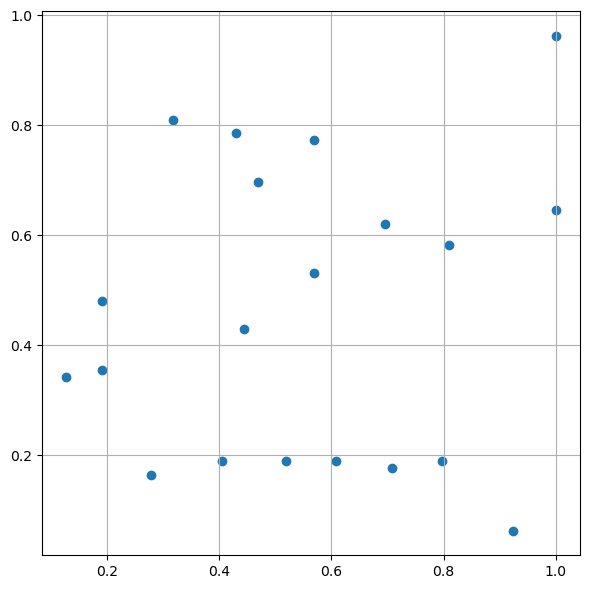

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(X_grid[S[:20], 0], X_grid[S[:20], 1])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def sample_int():
    return np.random.rand(2)

def sample_bdy():
    side = np.random.choice(4)
    t = np.random.rand()
    if side == 0:      # bottom edge: (t, 0)
        return np.array([t, 0.0])
    elif side == 1:    # right edge: (1, t)
        return np.array([1.0, t])
    elif side == 2:    # top edge: (t, 1)
        return np.array([t, 1.0])
    else:              # left edge: (0, t)
        return np.array([0.0, t])

def rpcq_unit_square(n, k, sample_int):
    L = jnp.zeros((n, n))
    S = []  # list of selected 2D points
    i = 0
    trials = 0
    k_vec = vmap(k, in_axes=(0, None))

    while i < n:
        trials += 1

        # Sample point uniformly from [0, 1]^2
        xi = sample_int()

        if len(S) == 0:
            d = k(xi, xi)
            c = jnp.array([])
        else:
            Xs = jnp.stack(S)
            Ks_si = k_vec(Xs, xi)
            c = solve_triangular(L[:i, :i], Ks_si, lower=True)
            d = k(xi, xi) - jnp.dot(c, c)

        # Rejection sampling
        U = np.random.rand()
        if U < d / k(xi, xi):
            print(i + 1, "point:", trials, "trials")
            S.append(xi)
            L = L.at[i, :i].set(c)
            L = L.at[i, i].set(jnp.sqrt(d))
            i += 1
            trials = 0

    return L, jnp.stack(S)

In [ ]:
L, points = rpcq_unit_square(100, lapx_lapy, sample_int)

0 th point: 1 trials
1 th point: 1 trials
2 th point: 1 trials
3 th point: 1 trials
4 th point: 1 trials
5 th point: 1 trials
6 th point: 1 trials
7 th point: 1 trials
8 th point: 1 trials
9 th point: 1 trials
10 th point: 1 trials
11 th point: 2 trials
12 th point: 1 trials
13 th point: 1 trials
14 th point: 1 trials
15 th point: 1 trials
16 th point: 1 trials
17 th point: 1 trials
18 th point: 2 trials
19 th point: 2 trials
20 th point: 2 trials
21 th point: 1 trials
22 th point: 10 trials
23 th point: 5 trials
24 th point: 1 trials
25 th point: 1 trials
26 th point: 2 trials
27 th point: 1 trials
28 th point: 3 trials
29 th point: 1 trials
30 th point: 1 trials
31 th point: 1 trials
32 th point: 1 trials
33 th point: 2 trials
34 th point: 2 trials
35 th point: 9 trials
36 th point: 3 trials
37 th point: 6 trials
38 th point: 2 trials
39 th point: 1 trials
40 th point: 7 trials
41 th point: 3 trials
42 th point: 4 trials
43 th point: 1 trials
44 th point: 9 trials
45 th point: 4 tria

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color='red', label="Selected Points", zorder=5)
plt.xlabel("x")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'points' is not defined

<Figure size 600x600 with 0 Axes>

In [ ]:
def rpcq_square_bdy(num_int, num_bdy, k_int, k_int_bdy, k_bdy, sample_int, sample_bdy):
    L = jnp.zeros((num_int + num_bdy, num_int + num_bdy))
    S = []  # list of selected 2D points
    i = 0
    trial = 0
    k_int_vec = vmap(k_int, in_axes=(0, None))
    k_bdy_vec = vmap(k_bdy, in_axes=(0, None))
    k_int_bdy_vec = vmap(k_int_bdy, in_axes=(0, None))


    while i < num_int:
        trial += 1
        # Sample point uniformly from [0, 1]^2
        xi = sample_int()

        if len(S) == 0:
            d = k_int(xi, xi)
            c = jnp.array([])
        else:
            Xs = jnp.stack(S)
            Ks_si = k_int_vec(Xs, xi)
            c = solve_triangular(L[:i, :i], Ks_si, lower=True)
            d = k_int(xi, xi) - jnp.dot(c, c)

        # Rejection sampling
        U = np.random.rand()
        if U < d / k_int(xi, xi):
            print("Int. point",i + 1, ":", trial, "trials")
            S.append(xi)
            L = L.at[i, :i].set(c)
            L = L.at[i, i].set(jnp.sqrt(d))
            i += 1
            trial = 0
    
    while i < num_int + num_bdy:
        trial += 1
        xi = sample_bdy()
        Xs = jnp.stack(S)
        # Evaluate cross-kernel entries
        K_int_part = k_int_bdy_vec(Xs[:num_int], xi)
        K_bdy_part = k_bdy_vec(Xs[num_int:i], xi)
        Ks_si = jnp.concatenate([K_int_part, K_bdy_part])
        c = solve_triangular(L[:i, :i], Ks_si, lower=True)
        d = k_bdy(xi, xi) - jnp.dot(c, c)

        # Rejection sampling
        U = np.random.rand()
        if U < d / k_bdy(xi, xi):
            print("Bdy. point",i - num_int + 1, ":", trial, "trials")
            S.append(xi)
            L = L.at[i, :i].set(c)
            L = L.at[i, i].set(jnp.sqrt(d))
            i += 1
            trial = 0

    X_int = S[:num_int]
    X_bdy = S[num_int:]

    return L, jnp.array(X_int), jnp.array(X_bdy)

In [ ]:
n_int = 50 
n_bdy = 20
L2, S_int, S_bdy = rpcq_square_bdy(n_int, n_bdy, lapx_lapy, lapx, k, sample_int, sample_bdy)


Int. point 1 : 1 iterations
Int. point 2 : 1 iterations
Int. point 3 : 1 iterations
Int. point 4 : 1 iterations
Int. point 5 : 1 iterations
Int. point 6 : 1 iterations
Int. point 7 : 1 iterations
Int. point 8 : 4 iterations
Int. point 9 : 1 iterations
Int. point 10 : 2 iterations
Int. point 11 : 3 iterations
Int. point 12 : 2 iterations
Int. point 13 : 3 iterations
Int. point 14 : 6 iterations
Int. point 15 : 1 iterations
Int. point 16 : 3 iterations
Int. point 17 : 3 iterations
Int. point 18 : 2 iterations
Int. point 19 : 2 iterations
Int. point 20 : 2 iterations
Int. point 21 : 3 iterations
Int. point 22 : 10 iterations
Int. point 23 : 7 iterations
Int. point 24 : 2 iterations
Int. point 25 : 9 iterations
Int. point 26 : 1 iterations
Int. point 27 : 14 iterations
Int. point 28 : 5 iterations
Int. point 29 : 11 iterations
Int. point 30 : 14 iterations
Int. point 31 : 4 iterations
Int. point 32 : 1 iterations
Int. point 33 : 8 iterations
Int. point 34 : 5 iterations
Int. point 35 : 10 

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(S_int[:, 0], S_int[:, 1])
plt.scatter(S_bdy[:, 0], S_bdy[:, 1 ])
plt.xlabel("x")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'S_int' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
K_11 = vec_lapx_lapy(S_int, S_int)
K_12 = vec_lapx(S_int, S_bdy)
K_21 = jnp.copy(K_12).T
K_22 = vec_k(S_bdy, S_bdy)

K = jnp.block([
    [K_11, K_12],
    [K_21, K_22]
    ])

print(np.max(abs(L2@L2.T - K)))

1.8189894035458565e-12
